# LPT Lightcone Simulation

This notebook builds a full lightcone using Lagrangian Perturbation Theory (LPT). While notebook 01 used a single scale factor, here we pass an **array** of scale factors to `lpt`, which produces density maps on spherical shells at each redshift.

The Zel'dovich approximation displaces particles from Lagrangian positions **q** to Eulerian positions:

$$\mathbf{x}(a) = \mathbf{q} + D(a)\,\boldsymbol{\Psi}(\mathbf{q})$$

The `scale_factor_spec` parameter controls how shells are defined:
- **Scalar**: single snapshot (returns `ParticleField`)
- **1D array**: center scale factors for lightcone shells
- **2D array** `(n_shells, 2)`: explicit near/far scale factors per shell

## Setup

In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'


import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Simulation Parameters

In [2]:
key = jax.random.PRNGKey(0)
resolution = 400
mesh_size = (resolution,) * 3
box_size = (1000.0,1000.0, 1000.0)
nside = resolution
flatsky_npix = (resolution,) * 2
field_size = (10, 10)
nb_shells = 4
cosmo = ffi.Planck18()

## Initial Conditions

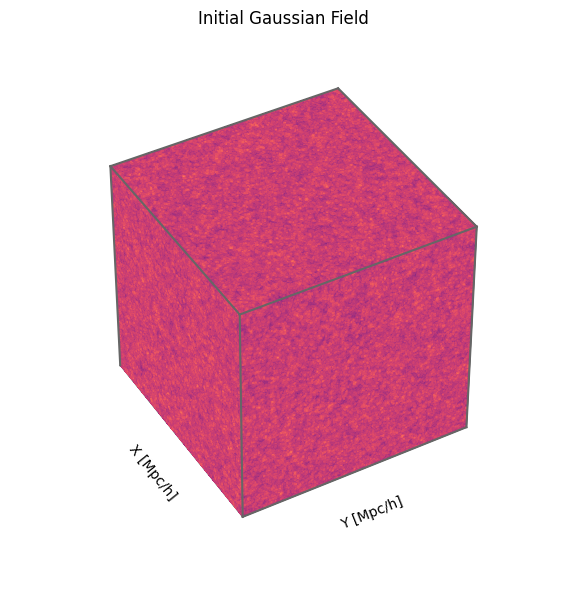

In [3]:
initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
)
initial_field.show(
    labels=["X [Mpc/h]", "Y [Mpc/h]", ""],
    colorbar=False,
    titles=["Initial Gaussian Field"],
)

## Lightcone Shell Configuration

`compute_lightcone_shells` divides the volume between the observer and the box boundary into `nb_shells` radial bins, returning comoving centers and corresponding scale factors. The shell geometry is derived from the box size and observer position stored in the `DensityField`.

Shell comoving centers [Mpc/h]: [437.5 312.5 187.5  62.5]
Shell scale factors: [0.86858717 0.90347696 0.94039979 0.97957846]
Shell redshifts: [0.15129493 0.10683509 0.06337752 0.02084727]


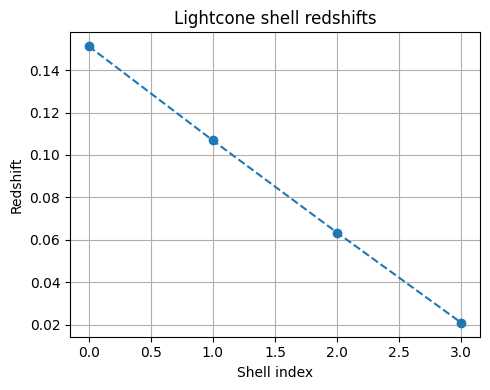

In [4]:
r_center, a_center = ffi.compute_lightcone_shells(cosmo, initial_field, nb_shells)
z_center = jc.utils.a2z(a_center)

print(f"Shell comoving centers [Mpc/h]: {r_center}")
print(f"Shell scale factors: {a_center}")
print(f"Shell redshifts: {z_center}")

fig = plt.figure(figsize=(5, 4))
plt.plot(jnp.arange(nb_shells), z_center, linestyle="--", marker="o")
plt.xlabel("Shell index")
plt.ylabel("Redshift")
plt.title("Lightcone shell redshifts")
plt.grid(True)
plt.tight_layout()
plt.show()

## scale_factor_spec Explained

When we pass the 1D array `a_center` to `lpt`, the function:
1. Computes bin edges from the center values
2. At each shell, evaluates LPT displacements at the center scale factor
3. Paints particles whose comoving distances fall within the shell boundaries

Without a `painting` option, `lpt` returns raw `ParticleField` objects. With `PaintingOptions`, it paints on-the-fly and returns density maps directly.

## LPT with Spherical Painting

In [5]:
spherical_dens, _ = ffi.lpt(
    cosmo, initial_field,
    scale_factor_spec=a_center,
    order=1,
    painting=ffi.PaintingOptions(target="spherical", scheme="bilinear"),
)

print(f"Output type: {type(spherical_dens).__name__}")
print(f"Shape: {spherical_dens.shape} (n_shells, npix)")
print(f"NSIDE: {spherical_dens.nside}")

Output type: SphericalDensity
Shape: (4, 1920000) (n_shells, npix)
NSIDE: 400


## Visualize Spherical Shells

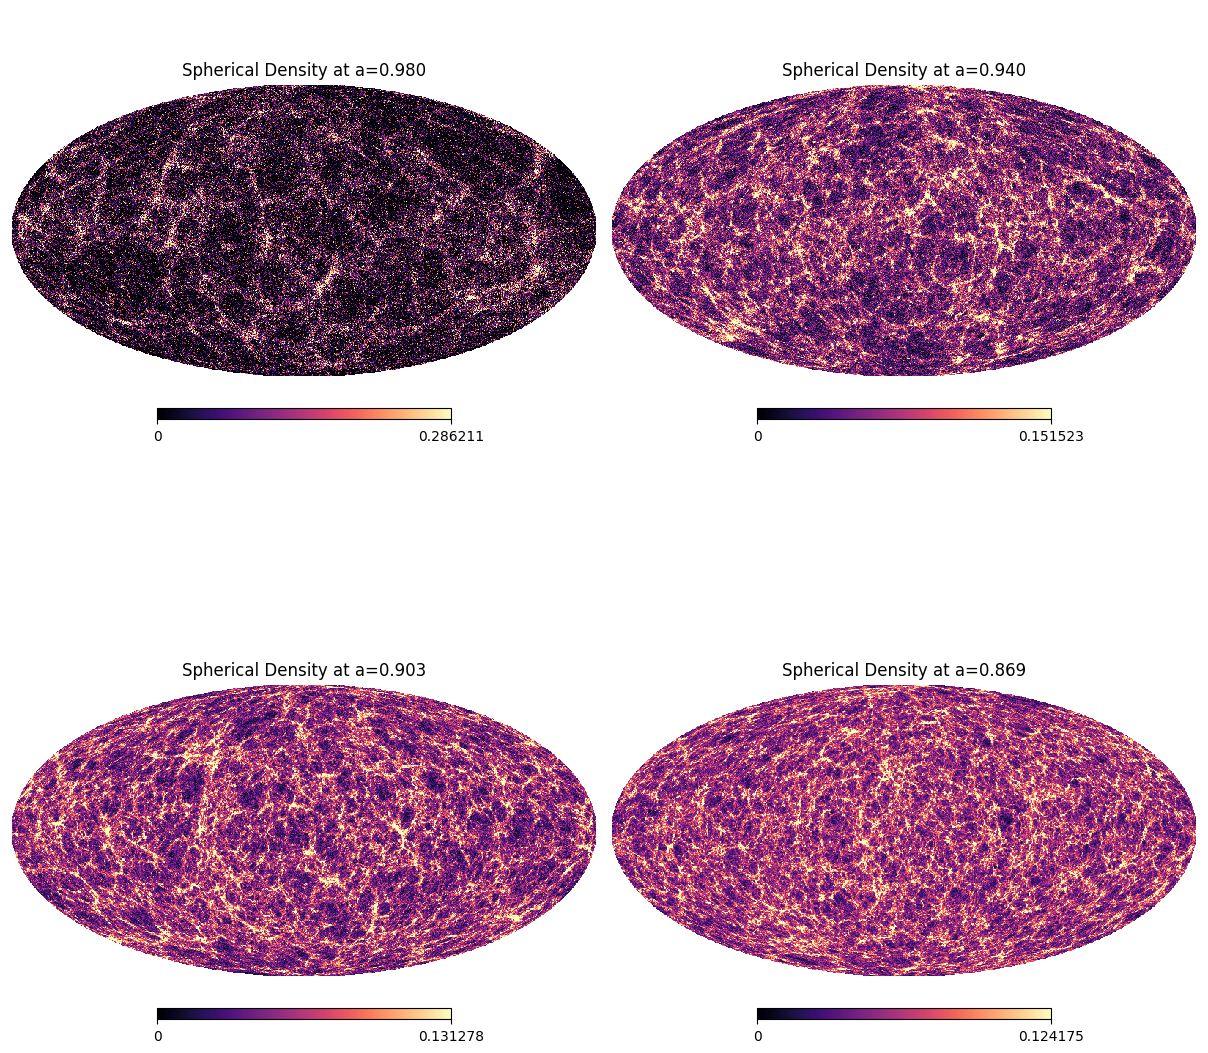

In [6]:
spherical_dens.show(ncols=2)

## Theory Comparison

For each shell, we define a top-hat redshift distribution spanning the shell boundaries and compute the predicted angular power spectrum using `compute_theory_cl`. The measured $C_\ell$ from `angular_cl` should agree with theory at large scales (low $\ell$), with deviations at small scales due to the finite particle resolution and CIC painting.

In [7]:
# Build redshift distributions for each shell
a_edges = ffi.edges(a_center)
a_near_far = jnp.stack([a_edges[1:], a_edges[:-1]], axis=-1)

z_centers = jc.utils.a2z(a_center)
z_sources = jc.utils.a2z(a_near_far)[::-1]
z_near, z_far = z_sources[..., 0], z_sources[..., 1]
nz_s = [ffi.tophat_z(n, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]

# Compute theory
LMAX = 3 * nside
ells = jnp.arange(LMAX)
theory_cl_ps = ffi.compute_theory_cl(
    cosmo, ell=ells, z_source=nz_s,
    probe_type="number_counts", nonlinear_fn="linear", cross=False,
)
sim_cl = spherical_dens.to(ffi.units.OVERDENSITY).angular_cl(method="healpy")

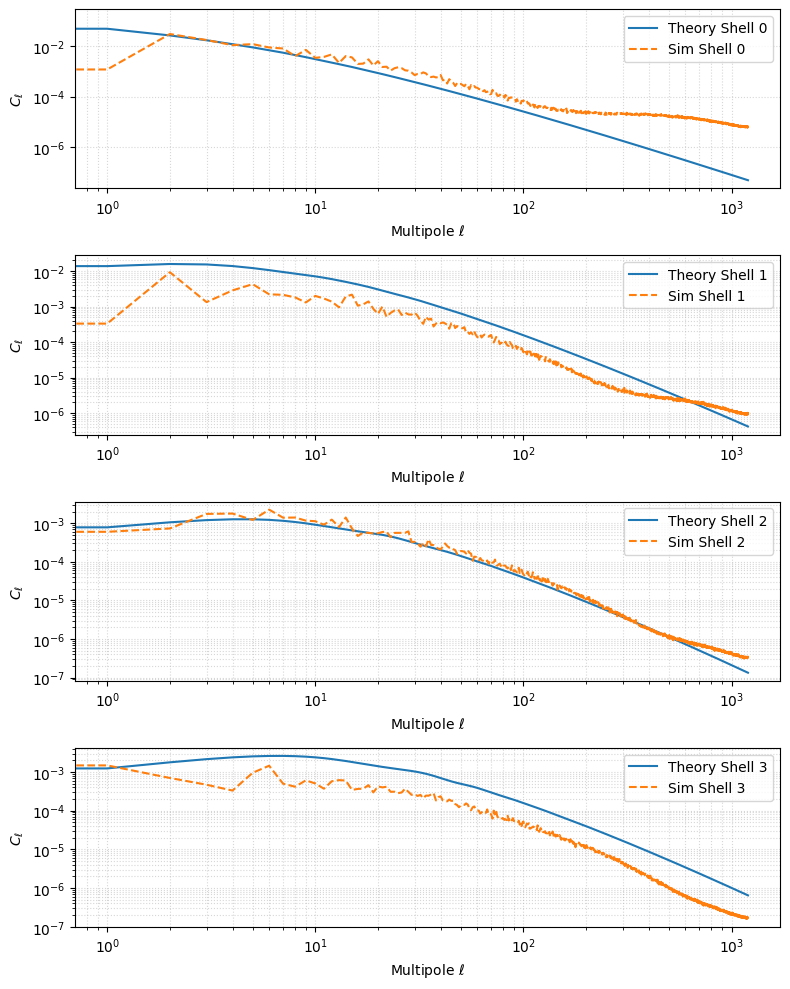

In [8]:
fig , ax = plt.subplots(4 , 1 , figsize=(8, 10))

for i in range(nb_shells):
    theory_cl_ps[i].plot(ax=ax[i], label=f"Theory Shell {i}")
    sim_cl[i].plot(ax=ax[i], label=f"Sim Shell {i}", linestyle="--")
    ax[i].set_xlabel("Multipole $\ell$")
    ax[i].set_ylabel("$C_\ell$")
    ax[i].legend()

plt.tight_layout()
plt.show()